Exercises:

1.Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?


In [96]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [97]:
words = open("names.txt", "r").read().splitlines()
chars = sorted(list(set("".join(words))))
stoi = {s:idx + 1 for idx, s in enumerate(chars)}
stoi["."] = 0
itos = {idx: s for s, idx in stoi.items()}
from itertools import product

chars_copy = chars.copy()
chars_copy.append(".")

chars2 = set()
for comb in product(chars_copy, repeat=2):
    chars2.add("".join(comb))

chars2 = sorted(list(chars2))
len(chars2)
stoi2 = {s:idx + 1 for idx, s in enumerate(chars2)}
stoi2[".."] = 0
itos2 = {idx: s for s, idx in stoi2.items()}
def build_three_grams(words):
    x, y = [], []

    for w in words:
        chs = ".." + w + "."
        for idx in range(0, len(chs) - 2):
            ch1, ch2, ch3 = chs[idx: idx + 2 + 1]
            idx1, idx2 = stoi2[ch1 + ch2], stoi[ch3] 
            x.append(idx1)
            y.append(idx2)

    x = torch.tensor(x)
    y = torch.tensor(y)

    return x, y
x, y = build_three_grams(words)
x[0]



tensor(0)

In [98]:
x.max()
x_enc = F.one_hot(x, num_classes=len(chars2) + 1).float()
x_enc.shape

torch.Size([228146, 730])

In [99]:
input_dim = x_enc.shape[1]
output_dim = 27

w = torch.randn((input_dim, output_dim), requires_grad=True)
w.shape
x_enc_i = x_enc[43]
x_enc_i = torch.tensor([x_enc_i.tolist()])
x_enc_i.shape
logits = x_enc_i @ w # predict log-counts
counts = logits.exp()
probas = counts / counts.sum(1, keepdims=True)
probas

tensor([[0.0018, 0.0097, 0.1827, 0.0120, 0.0918, 0.0434, 0.0018, 0.0076, 0.0195,
         0.3523, 0.0023, 0.0293, 0.0262, 0.0030, 0.0195, 0.0142, 0.0100, 0.0022,
         0.0131, 0.0103, 0.0132, 0.0036, 0.0902, 0.0062, 0.0042, 0.0173, 0.0127]],
       grad_fn=<DivBackward0>)

loss: 3.817260503768921
loss: 3.599616289138794
loss: 3.4778053760528564
loss: 3.3789777755737305
loss: 3.29512357711792
loss: 3.224256753921509
loss: 3.1640567779541016
loss: 3.1123416423797607
loss: 3.067185640335083
loss: 3.027212142944336
loss: 2.9914486408233643
loss: 2.9592034816741943
loss: 2.929949998855591
loss: 2.9032630920410156
loss: 2.878789186477661
loss: 2.8562300205230713
loss: 2.8353376388549805
loss: 2.8159103393554688
loss: 2.7977797985076904
loss: 2.7808072566986084
loss: 2.7648768424987793
loss: 2.749887704849243
loss: 2.7357542514801025
loss: 2.722400665283203
loss: 2.7097604274749756
loss: 2.697774887084961
loss: 2.6863901615142822
loss: 2.6755599975585938
loss: 2.665240526199341
loss: 2.655395030975342
loss: 2.6459882259368896
loss: 2.6369895935058594
loss: 2.628370761871338
loss: 2.620107650756836
loss: 2.6121768951416016
loss: 2.604557752609253
loss: 2.5972323417663574
loss: 2.5901827812194824
loss: 2.5833935737609863
loss: 2.5768508911132812
loss: 2.570540904

[]

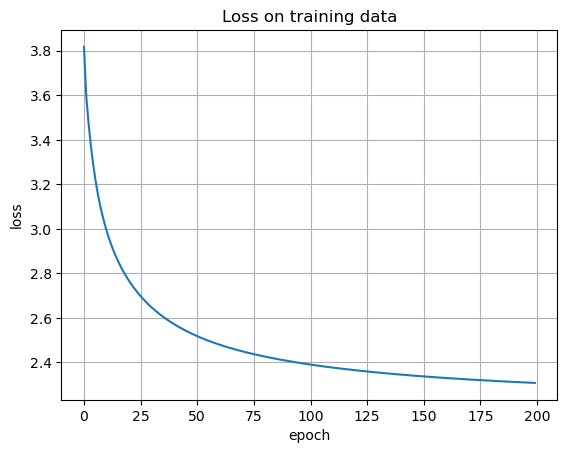

In [100]:
import torch.nn.functional as F

N_ITERS = 200
LEARN_RATE = 100
C = 0.01
losses = []


w = torch.randn((input_dim, output_dim), requires_grad=True)

for k in range(N_ITERS):
    logits = x_enc @ w # predict log-counts
    counts = logits.exp()
    probas = counts / counts.sum(1, keepdims=True)

    loss = -1 * probas[torch.arange(x_enc.shape[0]), y].log().mean() + C * (w ** 2).mean()
    print(f"loss: {loss.data}")
    losses.append(loss.data)

    w.grad = None
    loss.backward()

    w.data = w.data - LEARN_RATE * w.grad

print(f"train_loss (final): {losses[-1]}")
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss on training data")
plt.grid() 
plt.plot()

In [102]:
g = torch.Generator().manual_seed(616161)

for i in range(20):
    idx = 0
    generated_names = []

    i = 0
    while True:
        
        x_enc = F.one_hot(torch.tensor([idx]), num_classes=730).float()

        logits = x_enc @ w
        counts = logits.exp()
        p_dist = counts / counts.sum(1, keepdims=True)

        sampled_idx = torch.multinomial(p_dist, num_samples=1, replacement=True, generator=g).item()
        generated_names.append(itos[sampled_idx])
        
        idx = stoi2[itos2[idx][-1] + itos[sampled_idx]]

        if sampled_idx == stoi["."]:
            break

    print("generated_names:", "".join(generated_names))

generated_names: haiyarikasleimon.
generated_names: adelyna.
generated_names: kilah.
generated_names: coqou.
generated_names: aaqobi.
generated_names: de.
generated_names: jaana.
generated_names: gi.
generated_names: den.
generated_names: len.
generated_names: grknmnni.
generated_names: em.
generated_names: syceuxxagramoa.
generated_names: azjh.
generated_names: macmwen.
generated_names: ade.
generated_names: mer.
generated_names: mcsela.
generated_names: aymtqcy.
generated_names: hir.


2.Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?


In [68]:
m = x.shape[0]
rand_idxs = torch.randperm(m)
x = x[rand_idxs]
y = y[rand_idxs]

x_train = x[: int(0.8 * m)]
y_train = y[: int(0.8 * m)]
x_val = x[int(0.8 * m): int(0.9 * m)]
y_val = y[int(0.8 * m): int(0.9 * m)]
x_test = x[int(0.9 * m):]
y_test = y[int(0.9 * m):]
x_train_enc = F.one_hot(x_train, num_classes=len(chars2) + 1).float()
x_val_enc = F.one_hot(x_val, num_classes=len(chars2) + 1).float()
x_test_enc = F.one_hot(x_test, num_classes=len(chars2) + 1).float()

loss: 3.886678695678711
loss: 3.6551661491394043
loss: 3.523745059967041
loss: 3.416184663772583
loss: 3.3233492374420166
loss: 3.2436630725860596
loss: 3.175520658493042
loss: 3.1174917221069336
loss: 3.067817449569702
loss: 3.0249228477478027
loss: 2.9874136447906494
loss: 2.954216957092285
loss: 2.924534559249878
loss: 2.8977668285369873
loss: 2.873446464538574
loss: 2.851198196411133
loss: 2.830718517303467
loss: 2.811757802963257
loss: 2.79411244392395
loss: 2.7776143550872803
loss: 2.7621266841888428
loss: 2.747534990310669
loss: 2.7337467670440674
loss: 2.7206838130950928
loss: 2.708280563354492
loss: 2.6964824199676514
loss: 2.685241460800171
loss: 2.6745176315307617
loss: 2.664274215698242
loss: 2.6544792652130127
loss: 2.64510440826416
loss: 2.6361234188079834
loss: 2.6275129318237305
loss: 2.6192500591278076
loss: 2.6113154888153076
loss: 2.6036901473999023
loss: 2.5963566303253174
loss: 2.589298725128174
loss: 2.58250093460083
loss: 2.5759496688842773
loss: 2.56963229179382

[]

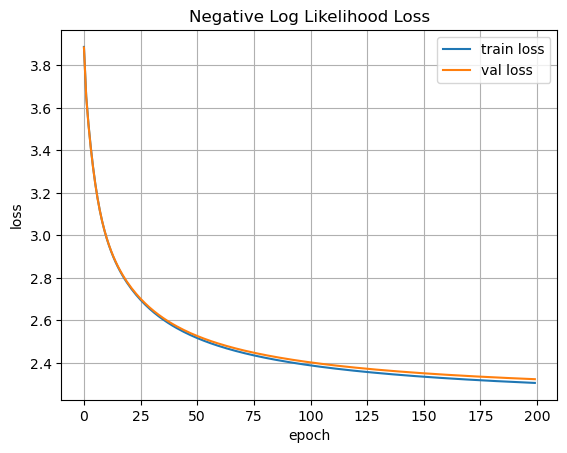

In [70]:
import torch.nn.functional as F

N_ITERS = 200
LEARN_RATE = 100
C = 0.01
train_losses = []
val_losses = []

w = torch.randn((input_dim, output_dim), requires_grad=True)

for k in range(N_ITERS):
    # Forward pass
    logits = x_train_enc @ w 
    counts = logits.exp()
    probas = counts / counts.sum(1, keepdims=True)

    train_loss = -1 * probas[torch.arange(x_train_enc.shape[0]), y_train].log().mean() + C * (w ** 2).mean()
    print(f"loss: {train_loss.data}")
    train_losses.append(train_loss.data)

    with torch.no_grad():
        logits_val = x_val_enc @ w 
        counts_val = logits_val.exp()
        probas_val = counts_val / counts_val.sum(1, keepdims=True)
        val_loss = -1 * probas_val[torch.arange(x_val_enc.shape[0]), y_val].log().mean()
        val_losses.append(val_loss)

    w.grad = None
    train_loss.backward()

    w.data = w.data - LEARN_RATE * w.grad
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Negative Log Likelihood Loss")
plt.legend()
plt.grid()
plt.plot()


3.Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?



 12%|█▎        | 1/8 [00:28<03:18, 28.40s/it]

tensor(2.2947) tensor(2.3249)


 25%|██▌       | 2/8 [00:57<02:51, 28.53s/it]

tensor(2.3067) tensor(2.3252)


 38%|███▊      | 3/8 [01:25<02:22, 28.52s/it]

tensor(2.3154) tensor(2.3245)


 50%|█████     | 4/8 [01:54<01:54, 28.55s/it]

tensor(2.3460) tensor(2.3266)


 62%|██████▎   | 5/8 [02:21<01:24, 28.18s/it]

tensor(2.3807) tensor(2.3261)


 75%|███████▌  | 6/8 [02:55<01:00, 30.06s/it]

tensor(2.4490) tensor(2.3378)


 88%|████████▊ | 7/8 [03:25<00:29, 29.95s/it]

tensor(2.5003) tensor(2.3624)


100%|██████████| 8/8 [03:54<00:00, 29.29s/it]

tensor(2.5621) tensor(2.4152)


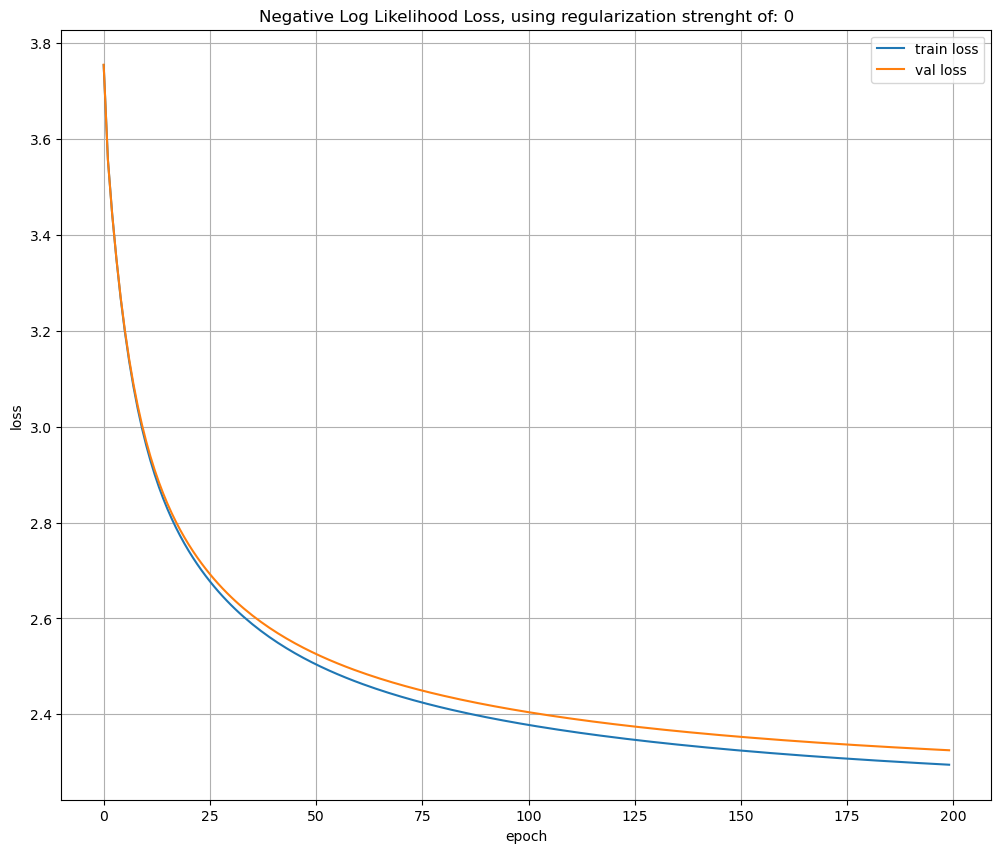

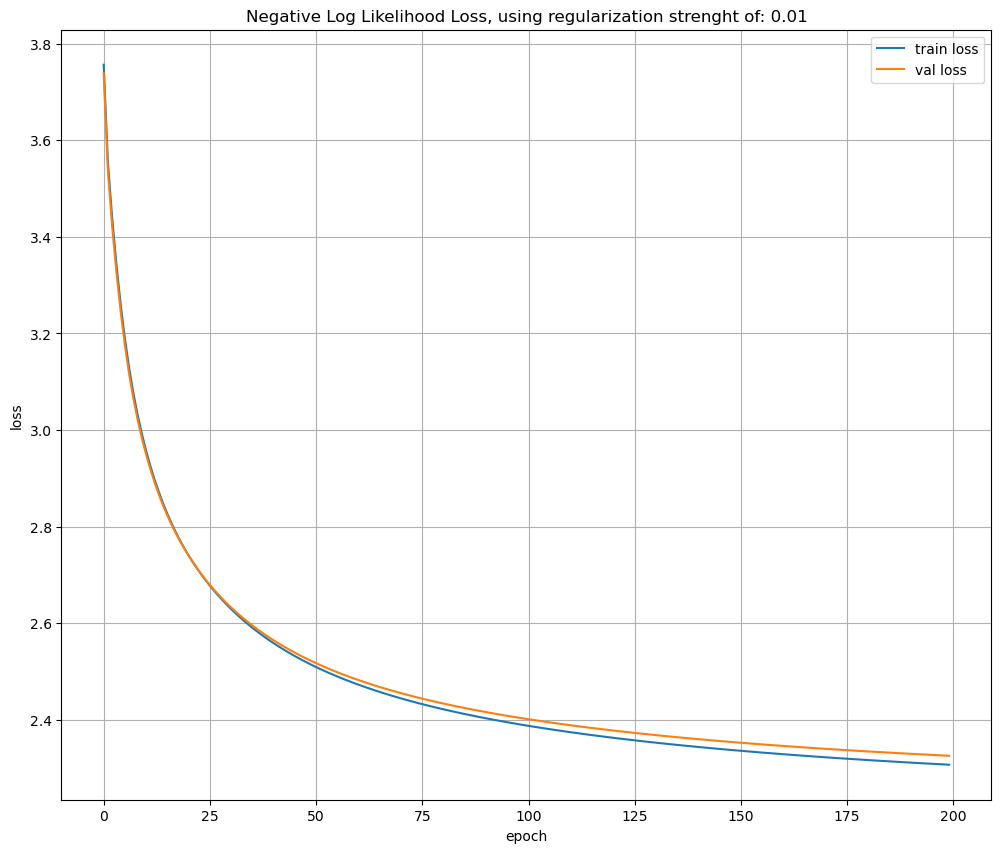

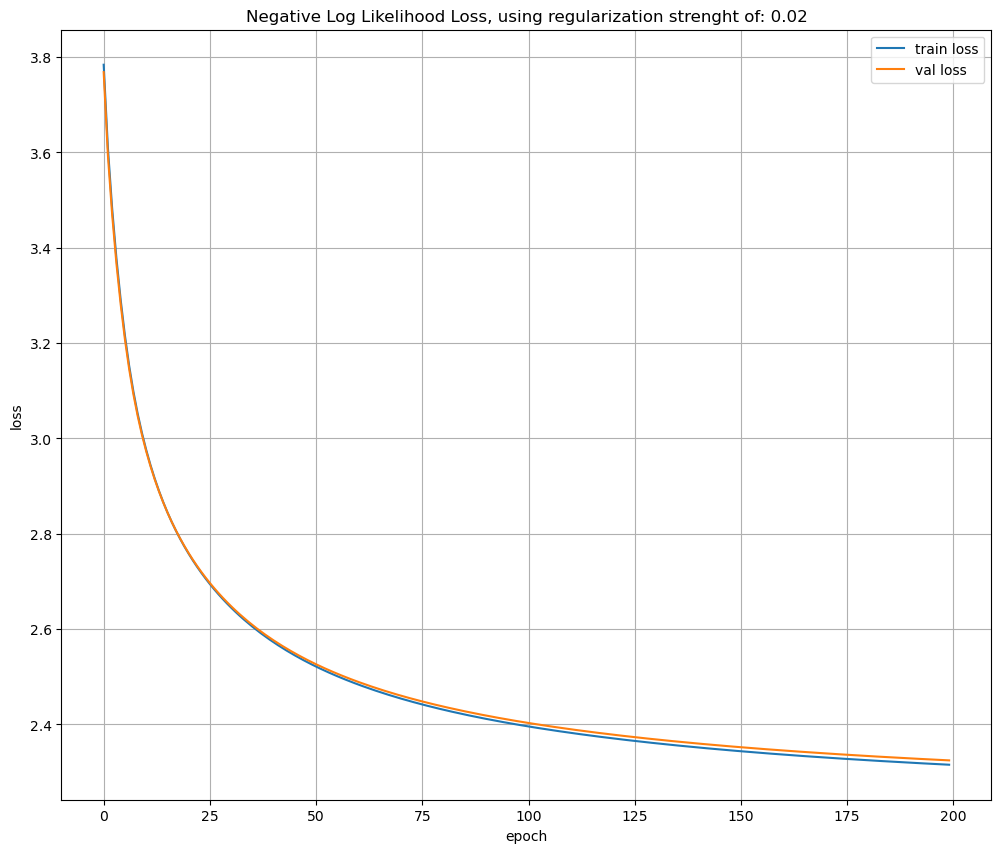

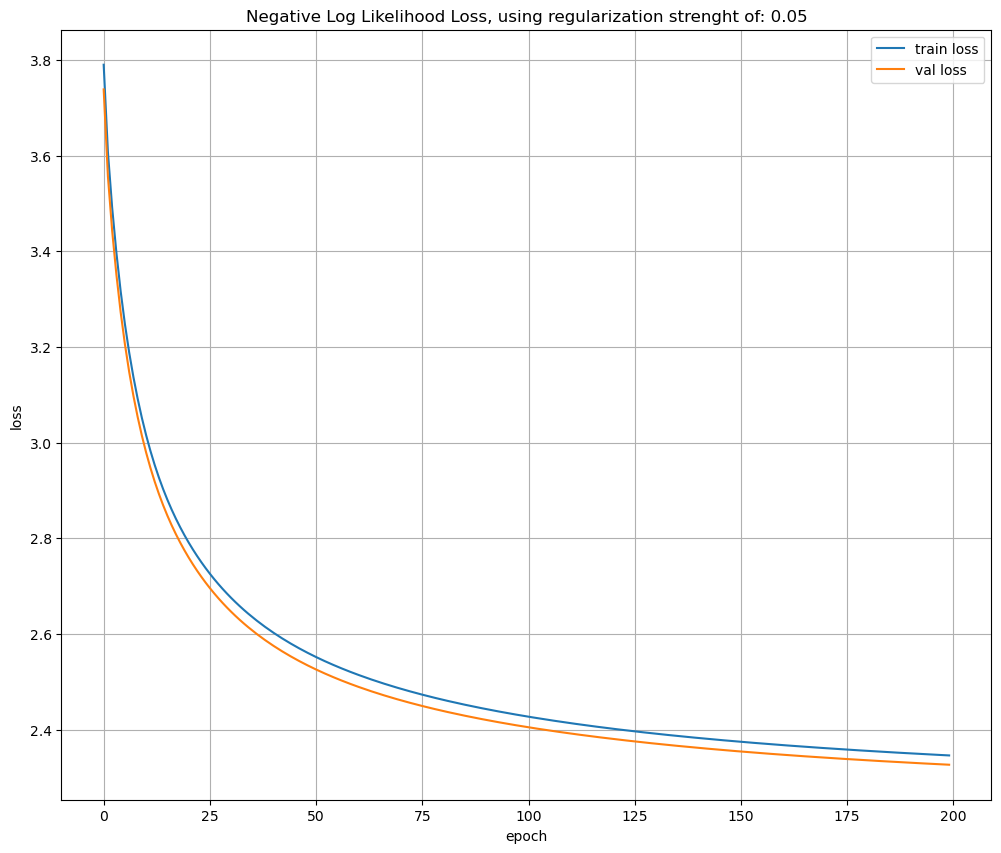

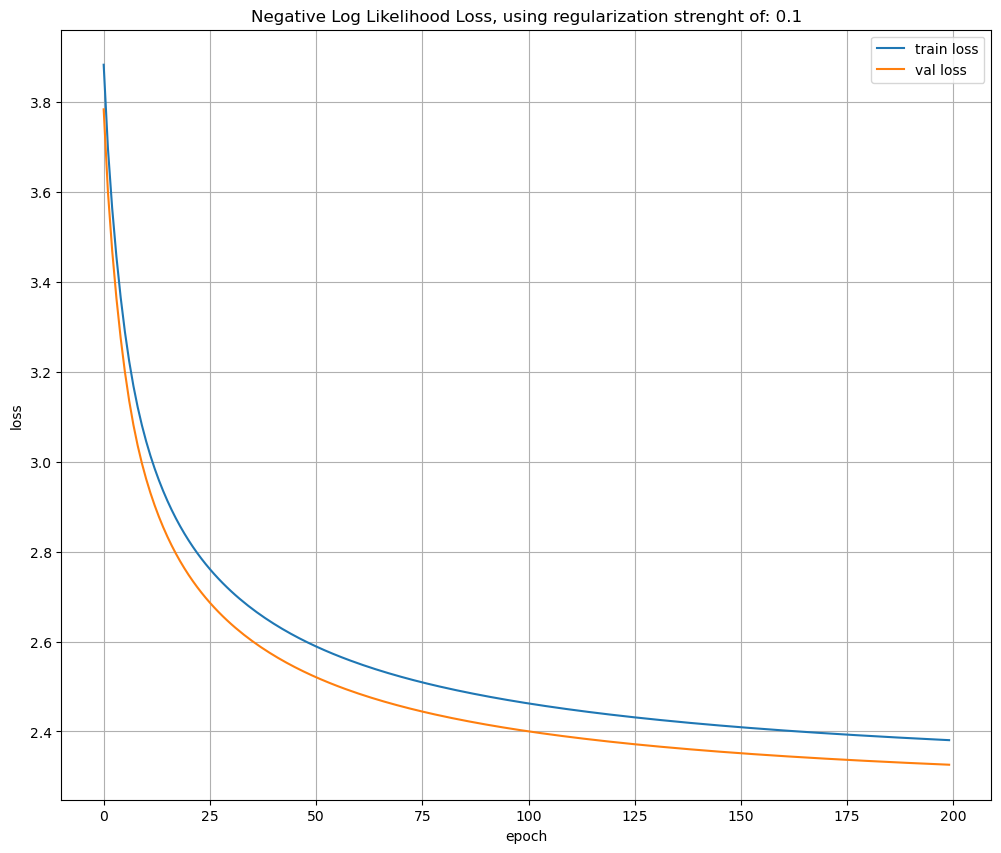

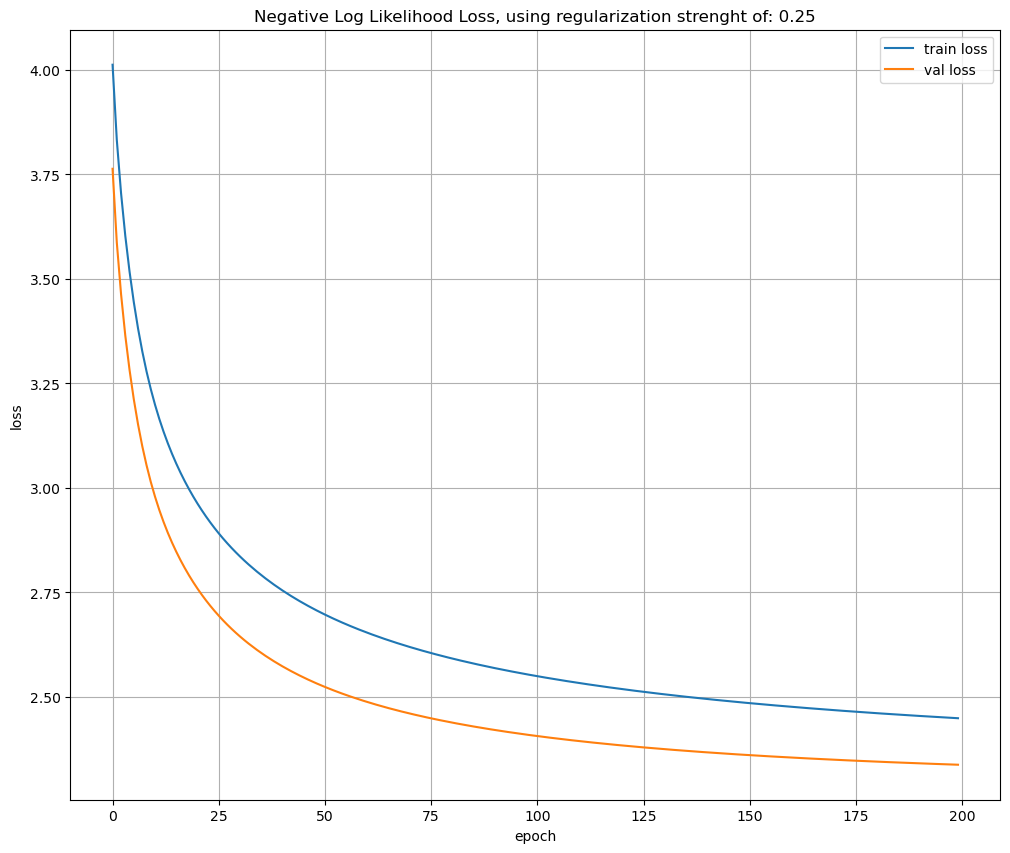

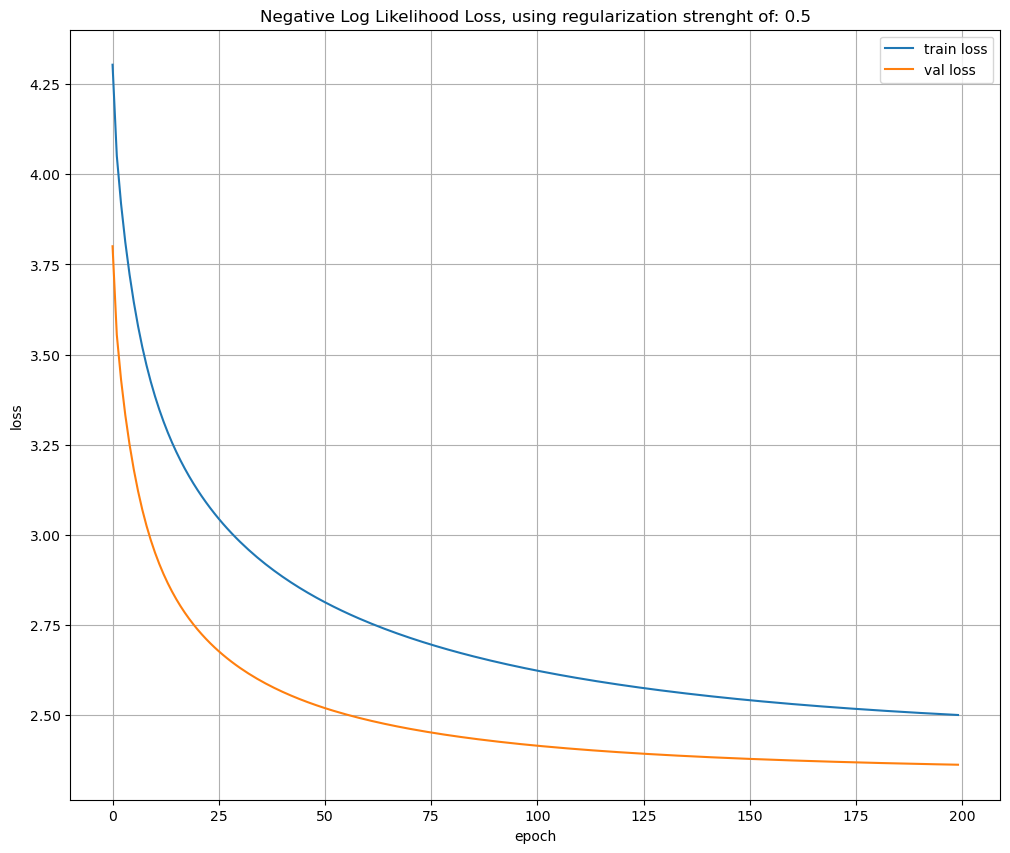

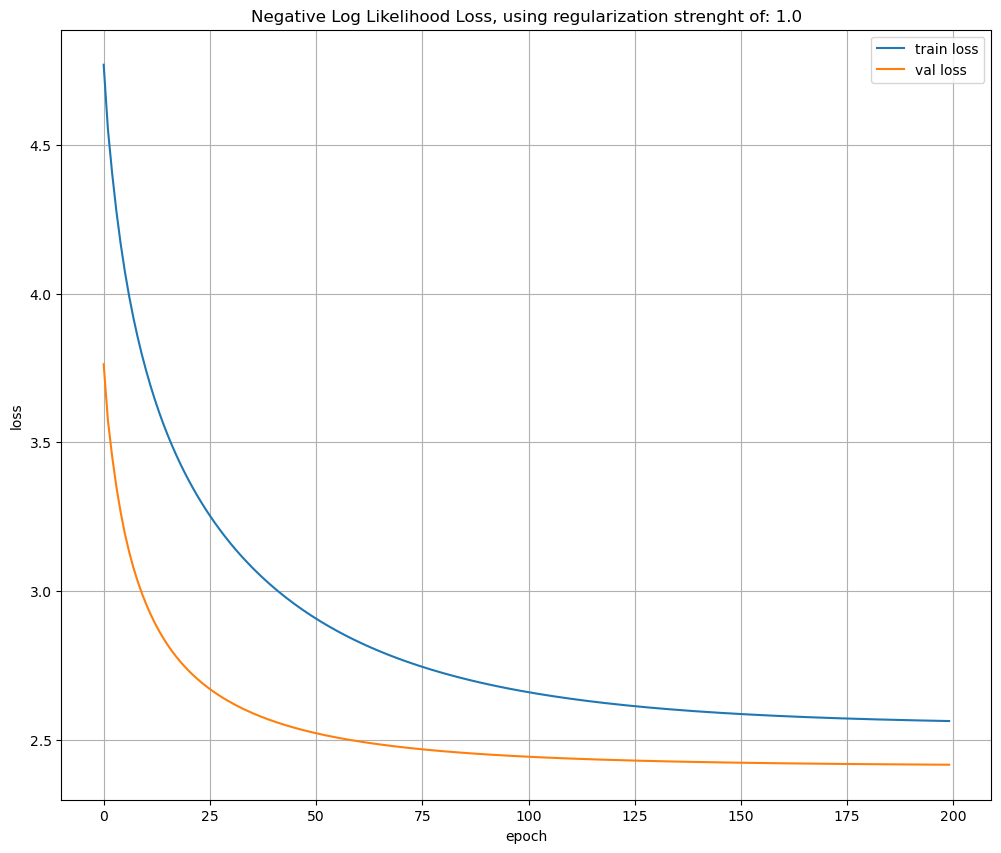

In [71]:
import torch.nn.functional as F
from tqdm import tqdm

N_ITERS = 200
LEARN_RATE = 100
reg_stenghts = [0, 0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 1.0]

w = torch.randn((input_dim, output_dim), requires_grad=True)
loss_dict = {} 
for reg_strength in tqdm(reg_stenghts):
    w = torch.randn((input_dim, output_dim), requires_grad=True)
    train_losses = []
    val_losses = []

    for k in range(N_ITERS):
        logits = x_train_enc @ w
        counts = logits.exp()
        probas = counts / counts.sum(1, keepdims=True)

        train_loss = -1 * probas[torch.arange(x_train_enc.shape[0]), y_train].log().mean() + reg_strength * (w ** 2).mean()
        train_losses.append(train_loss.data)
        print(f"loss: {train_loss.data}")

        with torch.no_grad():
            logits_val = x_val_enc @ w
            counts_val = logits_val.exp()
            probas_val = counts_val / counts_val.sum(1, keepdims=True)
            val_loss = -1 * probas_val[torch.arange(x_val_enc.shape[0]), y_val].log().mean()
            val_losses.append(val_loss)

        w.grad = None
        train_loss.backward()

        w.data = w.data - LEARN_RATE * w.grad

    print(train_losses[-1], val_losses[-1])
    loss_dict[reg_strength] = [train_losses[-1], val_losses[-1]]
    plt.figure(figsize=(12, 10))
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(f"Negative Log Likelihood Loss, using regularization strenght of: {reg_strength}")
    plt.legend()
    plt.grid() 
    plt.plot()

[]

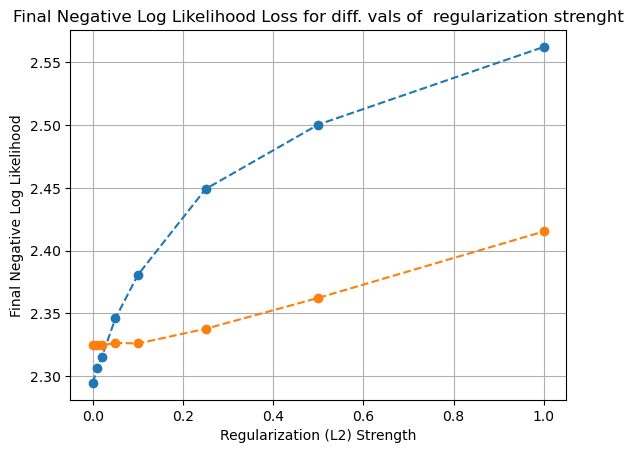

In [72]:
plt.title(f"Final Negative Log Likelihood Loss for diff. vals of  regularization strenght")
plt.plot(list(loss_dict.keys()), [train_loss for train_loss, _ in loss_dict.values()], "o--")
plt.plot(list(loss_dict.keys()), [val_loss for _, val_loss in loss_dict.values()], "o--")
plt.xlabel("Regularization (L2) Strength")
plt.ylabel("Final Negative Log Likelihood")
plt.grid()
plt.plot()

4.We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [82]:
x_enc = F.one_hot(x, num_classes=len(chars2) + 1).float()
x_enc = F.one_hot(x, num_classes=len(chars2) + 1).float()
x_enc_i @ w
x_i = x[132]


In [83]:
logits = w[x, :]
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -1 * prob[torch.arange(x.shape[0]), y].log().mean()
logits = x_enc @ w
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -1 * prob[torch.arange(x.shape[0]), y].log().mean()
loss

tensor(2.3966, grad_fn=<MulBackward0>)

5.Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [84]:
logits = w[x, :]
loss = F.cross_entropy(input=logits, target=y)
logits = x_enc @ w
loss = F.cross_entropy(input=logits, target=y)
loss

tensor(2.3966, grad_fn=<NllLossBackward0>)

In [85]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -1 * prob[torch.arange(x.shape[0]), y].log().mean()
loss

tensor(2.3966, grad_fn=<MulBackward0>)